In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.ticker as ticker
import os,sys
import struct
import scipy.integrate as integrate

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
from fractions import Fraction

import StrainandNoise as SnN

In [16]:
current_path = os.path.dirname(os.path.abspath('__file__'))
splt_path = current_path.split("/")
top_path_idx = splt_path.index('LisaParameterization')
top_directory = "/".join(splt_path[0:top_path_idx+1])
top_directory += '/lisaparameterization'

In [17]:
LISA_Other_filedirectory = top_directory + '/CommonLoadFiles/InstrumentStrainFiles/LISA_Other/'
LISA_Neil_filedirectory = top_directory + '/CommonLoadFiles/InstrumentStrainFiles/LISA_Neil/'
ET_filedirectory = top_directory + '/CommonLoadFiles/InstrumentStrainFiles/EinsteinTelescope/'
aLIGO_filedirectory = top_directory + '/CommonLoadFiles/InstrumentStrainFiles/aLIGO/'
NANOGrav_filedirectory = top_directory + '/CommonLoadFiles/InstrumentStrainFiles/NANOGrav/'
LISA_Transfer_Function_filedirectory = top_directory + '/CommonLoadFiles/LISATransferFunction/'
Numerical_Strain_filedirectory = top_directory + '/CommonLoadFiles/NumericalStrain/'
fit_coeffs_filedirectory = top_directory + '/CommonLoadFiles/PhenomDFiles/'
phenomD_filedirectory = top_directory + '/IMRPhenomD/'
fig_filedirectory = top_directory + '/StrainandNoiseCurves/PlottedStrainCurves/'    

In [18]:
#load python phenomD function
sys.path.insert(0,phenomD_filedirectory)
import pyFunPhenomDver1 as PhenomD

In [19]:
#Selects contour levels to separate sections into
#contLevels = np.array([10, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
contLevels = np.array([10, 1e2, 1e3, 1e4, 1e5])
logLevels = np.log10(contLevels)

contourcolorPresent = 'plasma'
transparencyPresent = 1.0
contourcolorFuture = 'plasma'
transparencyFuture = 1.0
axissize = 14
labelsize = 16
legendsize = 12
figsize = (10,8)
colornorm = colors.Normalize(vmin=0.0, vmax=5.0)
linesize = 2

In [20]:
L = 2.5*u.Gm  #armlength in Gm
L = L.to('m')

M = 1e6
q = 1.0
chi1 = 0.0
chi2 = 0.0
z = 5.0

S_acc_0 = 3e-15 #Unmodeled flat part of acceleration noise
S_imo_0 = 10e-12

nfreqs = int(1e3)

model = 2
recalculate = 'no'

isitsavetime = False

#Save Figure Name
figname = 'SensitivitySpectrum.eps'
figdpi = 1200
figformat = 'eps'

In [21]:
def calcPTAstrain(sigma_rms,cadence,T_obs,ndetectors,nfreqs):
    #####################################################
    #PSD of a PTA taken from eqn 40 of Thrane & Romano 2013
    #Equation 5 from https://arxiv.org/pdf/1808.10071.pdf
    
    #frequency range of full PTA
    f_year = 1/u.yr
    P_w_tot = 0
    T_obs_tot = 0
    if ndetectors != 1:
        #Sum of pulsar noises in different time periods divided by total time
        for i in range(ndetectors):
            P_w_n = sigma_rms[i]**2*(T_obs[i]/cadence[i]) #Avg white noise from pulsar arrays [s**2/Hz]
            P_w_tot += P_w_n
            T_obs_tot += T_obs[i]
        P_w = 2*P_w_tot/T_obs_tot
        f = np.logspace(np.log10(1/T_obs_tot.value),np.log10(min(cadence).value/2),nfreqs)*u.Hz
    else:
        P_w = 2*sigma_rms**2/cadence #Avg white noise from pulsar array [s**2/Hz]
        f = np.logspace(np.log10(1/T_obs.value),np.log10(cadence.value/2),nfreqs)*u.Hz
        
    #P_red = A_red.*(f./f_year).**(-gamma) # red noise for some pulsar
    P_red = 0.0*u.s*u.s/u.Hz #Assume no pulsar red noise for simplicity
    
    #eqn 42 of T&R
    #h_inst = np.sqrt((12*np.pi**2*(P_w+P_red))*f**3)
    ##################################################
    #Stochastic background amplitude from https://arxiv.org/pdf/1603.09348.pdf
    P_sb = (A_stoch_back**2/12/np.pi**2)*f**(-3)*(f/f_year.to('Hz'))**(-4/3)
    #h_sb = A_stoch_back*(f/f_year)**(-2/3)
    ####################################################
    #PSD of the full PTA from Lam 2018
    P_n = P_w + P_red + P_sb
    
    #strain of the full PTA
    h_f = np.sqrt((12*np.pi**2)*f**3*P_n)
    
    return f,h_f

#####################################################################
# Functions for Spectral Density Calculations

In [22]:
def calcASD(Sacc,Sims,L,fT, T):
    ASD = np.sqrt(20/3/T**2*(4*Sacc+Sims)/L**2)
    return np.sqrt(ASD**2+Sgal4yr(fT)) #Sqrt of PSD

In [23]:
def NeilSensitivity(Sacc,Soms,L,f,T):   
    #Uses Calculation described by Neil Cornish (unpublished)
    f_L = const.c/2/np.pi/L #Transfer frequency
    Pacc = (Sacc)**2*(1+(0.4e-3*u.Hz/f)**2)*(1+(f/(8e-3*u.Hz))**4) #acceleration noise [Hz]**-1
    Poms = (Soms)**2*(1+(2e-3*u.Hz/f)**4) #Optical metrology noise [Hz]**-1
    
    P_n_f = Poms/L**2 + 2*(1.0+(np.cos(f.value/f_L.value))**2)*Pacc/(2*np.pi*f)**4/L**2 #Total noise
    R_f = 3/10/(1+0.6*(f/f_L)**2) #Response function approximation
    #ASD = sqrt(P_n_f./R_f+S_c) #Amplitude Spectral Density
    return np.sqrt(10/3/T**2*P_n_f+Sgal4yr(f))

In [24]:
def Sgal4yr(f):
    #4 year Galactic confusions noise parameters
    A = 9e-45
    a = 0.138
    b = -221
    k = 521
    g = 1680
    f_k = 0.00113
    return A*np.exp(-(f.value**a)+(b*f.value*np.sin(k*f.value)))*(f.value**(-7/3))*(1 + np.tanh(g*(f_k-f.value))) #White Dwarf Background Noise


In [25]:
def Get_CharStrain(Vars,f,h):
    [M,q,chi1,chi2,z] = np.split(Vars,len(Vars))
    DL = cosmo.luminosity_distance(z)
    
    m_conv = const.G*const.M_sun/const.c**3 #Converts M = [M] to M = [sec]

    eta = q/(1+q)**2
    M_redshifted_time = M*(1+z)*m_conv
    M_chirp = eta**(3/5)*M_redshifted_time
    
    freq_conv = 1/M_redshifted_time
    strain_conv = np.sqrt(5/16/np.pi)*(const.c/DL.to('m'))*M_redshifted_time**2
    
    f = f*freq_conv
    h = h*strain_conv
    h_char = np.sqrt(4*f**2*h**2)
    return [f,h_char]

In [26]:
def Get_Waveform(Vars,nfreqs):
    fit_coeffs_filename = 'fitcoeffsWEB.dat'
    fit_coeffs_file = fit_coeffs_filedirectory + fit_coeffs_filename
    fitcoeffs = np.loadtxt(fit_coeffs_file) #load QNM fitting files for speed later

    [phenomD_f,phenomD_h] = PhenomD.FunPhenomDver8(Vars,fitcoeffs,nfreqs)
    return Get_CharStrain(Vars,phenomD_f,phenomD_h)

####################################################################
# Load data files for transfer function and other sensitivity curves

### LISA Transfer Function

In [27]:
LISA_Transfer_Function_filename = 'transfer.dat' #np.loadtxting transfer function for Lisa noise curve
LISA_Transfer_Function_filelocation = LISA_Transfer_Function_filedirectory + LISA_Transfer_Function_filename
LISA_Transfer_Function_data = np.loadtxt(LISA_Transfer_Function_filelocation)
fc = const.c/(2*L)  #light round trip freq
LISA_Transfer_Function_f = fc*LISA_Transfer_Function_data[:,0]

idx_f_5 = np.abs(LISA_Transfer_Function_f-1e-5*u.Hz).argmin()
idx_f_1 = np.abs(LISA_Transfer_Function_f-1.0*u.Hz).argmin()

LISA_Transfer_Function = LISA_Transfer_Function_data[idx_f_5:idx_f_1,1]
LISA_Transfer_Function_f = LISA_Transfer_Function_f[idx_f_5:idx_f_1]

### aLIGO

In [28]:
#aLIGO
aLIGO_filename = 'aLIGODesign.txt'
aLIGO_filelocation = aLIGO_filedirectory + aLIGO_filename
aLIGO_data = np.loadtxt(aLIGO_filelocation)
aLIGO_f = aLIGO_data[:,0]*u.Hz
aLIGO_S_n_f = aLIGO_data[:,1]

### Einstein Telescope

In [29]:
#Einstein Telescope
ET_filename = 'ET_B_data.txt'
ET_filelocation = ET_filedirectory + ET_filename
ET_data = np.loadtxt(ET_filelocation)
ET_f = ET_data[:,0]*u.Hz
ET_S_n_f = ET_data[:,1]

### LISA Martin data

In [30]:
#Martin data
LISA_Martin_filename = 'LISA_Allocation_S_h_tot.txt'
LISA_Martin_filelocation = LISA_Other_filedirectory + LISA_Martin_filename
LISA_Martin_data = np.loadtxt(LISA_Martin_filelocation)
LISA_Martin_f = LISA_Martin_data[:,0]*u.Hz
LISA_Martin_S_n_f = LISA_Martin_data[:,1]/u.Hz

### LISA Neil Cornish data

In [31]:
#Neil Cornish data
LISA_Neil_filename = 'LISA_sensitivity.txt'
LISA_Neil_filelocation = LISA_Neil_filedirectory + LISA_Neil_filename
LISA_Neil_data = np.loadtxt(LISA_Neil_filelocation)
LISA_Neil_f = LISA_Neil_data[:,0]*u.Hz
LISA_Neil_S_n_f = LISA_Neil_data[:,1]/u.Hz

### LISA Larson Sensitivity Curve

In [32]:
#Larson Sensitivity Curve
LISA_Larson_filename = 'scg_6981.dat'
LISA_Larson_filelocation = LISA_Other_filedirectory + LISA_Larson_filename
LISA_Larson_data = np.loadtxt(LISA_Larson_filelocation)
LISA_Larson_f = LISA_Larson_data[:,0]*u.Hz
LISA_Larson_S_n_f = LISA_Larson_data[:,1]/u.Hz #May be wrong units

### NANOGrav continuous wave sensitivity

In [33]:
#NANOGrav continuous wave sensitivity
NANOGrav_filename = 'cw_simulation_Ared_0_dp_0.5_fap_0.0001_T_15.txt'
NANOGrav_filelocation = NANOGrav_filedirectory + NANOGrav_filename
NANOGrav_data = np.loadtxt(NANOGrav_filelocation)
NANOGrav_f = NANOGrav_data[:,0]*u.Hz
NANOGrav_h_f = NANOGrav_data[:,1]

### SKA  parameters and methods from arXiv:0804.4476 section 7.1

In [34]:
###############################################
#SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
deltrms_SKA = 10*u.ns #rms timing residuals in nanoseconds
deltrms_SKA = deltrms_SKA.to('s')

T_SKA = 20*u.yr #Observing time in years
T_SKA = T_SKA.to('s') #Observing time in seconds

Np_SKA = 20 #Number of pulsars
cadence_SKA = 1/u.wk #Avg observation cadence of 1 every week in seconds
cadence_SKA = cadence_SKA.to('1/s')
A_stoch_back = 4e-16 #Stochastic background amplitude from https://arxiv.org/pdf/1603.09348.pdf

### NANOGrav 11.5yr parameters https://arxiv.org/abs/1801.01837

In [47]:
###############################################
#NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
deltrms_nano = 100*u.ns #rms timing residuals in seconds
deltrms_nano = deltrms_nano.to('s')

T_nano = 11.4*u.yr #Observing time in years
T_nano = T_nano.to('s') #Observing time in seconds
Np_nano = 45 #Number of pulsars
cadence_nano = 1/(2*u.wk) #Avg observation cadence of 1 every 2 weeks in seconds
cadence_nano = cadence_nano.to('1/s')

# Calculate PTA Strains using Lam, M.T. 2018 https://arxiv.org/pdf/1808.10071.pdf

In [45]:
ndetectors = 2
#Sample from 1/Tobs to nyquist freq
T_obs_full = [T_nano, T_SKA]
cadence_full = [cadence_nano, cadence_SKA]
sigma_rms_full = [deltrms_nano, deltrms_SKA]

SKA_f,SKA_h_f = calcPTAstrain(sigma_rms_full,cadence_full,T_obs_full,ndetectors,nfreqs)

In [48]:
SKA_f_tmp,SKA_h_f_tmp = SnN.calcPTAstrain(sigma_rms_full,cadence_full,T_obs_full,ndetectors,nfreqs)

In [37]:
#Sample from 1/Tobs to nyquist freq
ndetectors = 1

NANOGrav_approx_f,NANOGrav_approx_h_f = calcPTAstrain(deltrms_nano,cadence_nano,T_nano,ndetectors,nfreqs)

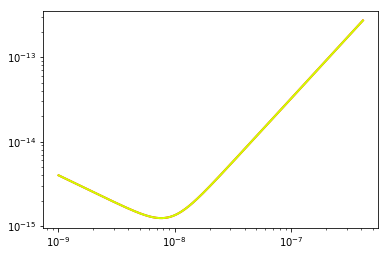

In [51]:
plt.figure()
plt.loglog(SKA_f,SKA_h_f, linewidth = linesize,color = cm.hsv(colornorm(0.0)),label = 'IPTA ~2030s')
plt.loglog(SKA_f_tmp,SKA_h_f_tmp, linewidth = linesize,color = cm.hsv(colornorm(1.0)),label = 'SKA ~2030s')
plt.show()

####################################################################
# Calculate LISA amplitude spectral densities for various models

### LISA Calculation without pathfinder correction (2016 model)

In [ ]:
#LISA Calculation without pathfinder correction (2016 model)
Ssci = 8.9e-12**2*u.m*u.m
Sloc = 1.7e-12**2*u.m*u.m
Sother = 2e-12**2*u.m*u.m
k2016_S_ims = Ssci+2*Sloc+Sother
k2016_S_acc = ((1.8e-14*u.m/u.s/u.s)**2*((3e-5*u.Hz/LISA_Transfer_Function_f)**10 + (1e-4*u.Hz/LISA_Transfer_Function_f)**2) + (3e-15*u.m/u.s/u.s)**2)/(2*np.pi*LISA_Transfer_Function_f)**4   #red below 1e-4, white above
k2016_S_n_f = calcASD(k2016_S_acc,k2016_S_ims,L,LISA_Transfer_Function_f,LISA_Transfer_Function)

### LISA Calculation WITH (Sean's) pathfinder correction

In [ ]:
#LISA Calculation WITH (Sean's) pathfinder correction
pathfinder_S_acc = ((60e-15*u.m/u.s/u.s)**2*(20e-6*u.Hz/LISA_Transfer_Function_f)**10 + (1.74e-15*u.m/u.s/u.s)**2)/(2*np.pi*LISA_Transfer_Function_f)**4 #Update Pathfinder Acceleration Noise
pathfinder_S_n_f = calcASD(pathfinder_S_acc,k2016_S_ims,L,LISA_Transfer_Function_f,LISA_Transfer_Function) #Updated LISA noise curve with Pathfinder Acc noise

### LISA Calculation from https://arxiv.org/pdf/1702.00786.pdf (Amaro-Seaone 2017)

In [75]:
#LISA Calculation from https://arxiv.org/pdf/1702.00786.pdf (Amaro-Seaone 2017)
ESA_S_acc = (3e-15*u.m/u.s/u.s)**2*(1+(0.4e-3*u.Hz/LISA_Transfer_Function_f)**2)*(1+(LISA_Transfer_Function_f/(8e-3*u.Hz))**4)/(2*np.pi*LISA_Transfer_Function_f)**4 #Acceleration Noise 
ESA_S_ifo = (10e-12*u.m)**2*(1+(2e-3*u.Hz/LISA_Transfer_Function_f)**4) #Displacement noise of the interferometric TM--to-TM 
ESA_S_n_f = calcASD(ESA_S_acc,ESA_S_ifo,L,LISA_Transfer_Function_f,LISA_Transfer_Function)

In [80]:
S_acc_low_knee = .4*u.mHz
S_acc_high_knee = 8.*u.mHz
S_oms_knee = 2.*u.mHz
ESA_S_n_f_tmp = SnN.LisaSensitivity(LISA_Transfer_Function_f,LISA_Transfer_Function)

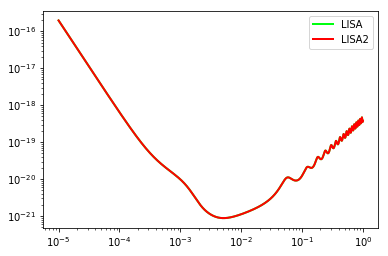

In [81]:
plt.figure()
plt.loglog(LISA_Transfer_Function_f,np.sqrt(LISA_Transfer_Function_f)*ESA_S_n_f, linewidth = linesize,color = cm.hsv(colornorm(1.75)),label = 'LISA')
plt.loglog(LISA_Transfer_Function_f,np.sqrt(LISA_Transfer_Function_f)*ESA_S_n_f_tmp, linewidth = linesize,color = cm.hsv(colornorm(0.0)),label = 'LISA2')
plt.legend()
plt.show()

### Neil Calculation from https://arxiv.org/pdf/1803.01944.pdf

In [82]:
#Neil Calculation from https://arxiv.org/pdf/1803.01944.pdf
Neil_S_acc = 3e-15*u.m/u.s/u.s #M/sqrt(Hz)
Neil_S_oms = 1.5e-11*u.m
Neil_L = 2.5e9*u.m
Neil_S_n_f = NeilSensitivity(Neil_S_acc,Neil_S_oms,Neil_L,LISA_Transfer_Function_f,LISA_Transfer_Function)

In [87]:
Neil_S_n_f_tmp1 = SnN.NeilSensitivity(LISA_Transfer_Function_f,LISA_Transfer_Function)
Neil_S_n_f_tmp2 = SnN.LisaSensitivity(LISA_Transfer_Function_f,LISA_Transfer_Function,S_ims=Neil_S_oms,)

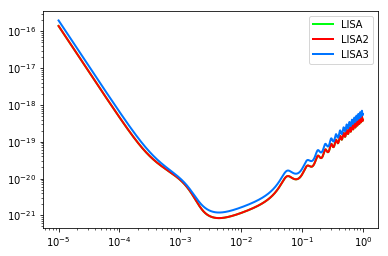

In [88]:
plt.figure()
plt.loglog(LISA_Transfer_Function_f,np.sqrt(LISA_Transfer_Function_f)*Neil_S_n_f, linewidth = linesize,color = cm.hsv(colornorm(1.75)),label = 'LISA')
plt.loglog(LISA_Transfer_Function_f,np.sqrt(LISA_Transfer_Function_f)*Neil_S_n_f_tmp1, linewidth = linesize,color = cm.hsv(colornorm(0.0)),label = 'LISA2')
plt.loglog(LISA_Transfer_Function_f,np.sqrt(LISA_Transfer_Function_f)*Neil_S_n_f_tmp2, linewidth = linesize,color = cm.hsv(colornorm(3.0)),label = 'LISA3')
plt.legend()
plt.show()

#######################################################################
# BBH strain calculation

In [ ]:
#Vars = [M,q,chi1,chi2,z]
M = [1e6,65.0,1e10]
q = [1.0,1.0,1.0]
x1 = [0.0,0.0,0.0]
x2 = [0.0,0.0,0.0]
z = [3.0,0.093,20.0]

Vars1 = np.array([M[0],q[0],x1[0],x2[0],z[0]])
Vars2 = np.array([M[1],q[1],x1[1],x2[1],z[1]])
Vars3 = np.array([M[2],q[2],x1[2],x2[2],z[2]])

In [ ]:
#From File/Numerical simulation
numericalStrain_filename = 'hmbhfft.dat'
numericalStrain_filelocation = Numerical_Strain_filedirectory + numericalStrain_filename
numericalStrain_data = np.loadtxt(numericalStrain_filelocation)
numericalStrain_f = numericalStrain_data[:,0]*u.Hz
numericalStrain_h = numericalStrain_data[:,1]

In [ ]:
[numericalStrain_f, numericalStrain_h_char] = Get_CharStrain(Vars1,numericalStrain_f,np.sqrt(2)*numericalStrain_h) #Unsure why sqrt(2)

In [ ]:
#From PhenomD
[phenomD_f_1,phenomD_h_char_1] = Get_Waveform(Vars1,nfreqs)
[phenomD_f_2,phenomD_h_char_2] = Get_Waveform(Vars2,nfreqs)
[phenomD_f_3,phenomD_h_char_3] = Get_Waveform(Vars3,nfreqs)

In [ ]:
plt.figure(figsize = figsize)
#plt.loglog(NANOGrav_f,NANOGrav_h_f)
plt.loglog(SKA_f,SKA_h_f, linewidth = linesize,color = cm.hsv(colornorm(0.0)),label = 'IPTA ~2030s')
plt.loglog(NANOGrav_approx_f,NANOGrav_approx_h_f, linewidth = linesize,color = cm.hsv(colornorm(0.5)),label = 'NANOGrav (11yr)')
plt.loglog(LISA_Transfer_Function_f,np.sqrt(LISA_Transfer_Function_f)*ESA_S_n_f, linewidth = linesize,color = cm.hsv(colornorm(1.75)),label = 'LISA')
plt.loglog(aLIGO_f,np.sqrt(aLIGO_f)*aLIGO_S_n_f,color = cm.hsv(colornorm(2.8)),label = 'aLIGO')
plt.loglog(ET_f,np.sqrt(ET_f)*ET_S_n_f, linewidth = linesize,color = cm.hsv(colornorm(2.5)),label = 'Einstein Telescope')
plt.loglog(phenomD_f_1,phenomD_h_char_1, linewidth = linesize,color = cm.hsv(colornorm(0.8)),label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.1f$' %(M[0],q[0],z[0],x1[0]))
plt.loglog(phenomD_f_2,phenomD_h_char_2, linewidth = linesize,color = cm.hsv(colornorm(3.0)),label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.1f$' %(M[1],q[1],z[1],x1[1]))
plt.loglog(phenomD_f_3,phenomD_h_char_3, linewidth = linesize,color = cm.hsv(colornorm(4.5)),label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.1f$' %(M[2],q[2],z[2],x1[2]))
#plt.loglog(numericalStrain_f,numericalStrain_h_char)

plt.xlim([8e-10, 1e4])
plt.ylim([1e-24, 1e-11])
plt.tick_params(axis = 'both',which = 'major', labelsize = axissize)

plt.xlabel('Frequency [Hz]',fontsize = labelsize)
plt.ylabel('Characteristic Strain',fontsize = labelsize)
plt.legend(loc='upper right', fontsize = legendsize)
plt.show()

In [ ]:
#########################
#Save Figure to File
figloc = fig_filedirectory+figname
if isitsavetime:
    plt.savefig(figloc, format=figformat, dpi=figdpi)